# Discrete Fourier Transform

## Part 1

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

print("Input Sine Wave Signal:")
N = 360 # degrees (Number of samples)
a = random.randint(1, 100)
f = random.randint(1, 50)
p = random.randint(0, 360)
print("frequency = {:3d}".format(f))
print("amplitude = {:3d}".format(a))
print("phase ang = {:3d}".format(p))

Input Sine Wave Signal:
frequency =  31
amplitude =   9
phase ang = 235


### Manually calculate the inverse Fourier transform

We can calculate the sine wave with $A\sin(ft + \phi)$. Because we are working in degrees, and Python's `sin()` function only understands radians, we need to convert using the `radians()` function.

In [2]:
from math import sin, pi, radians

f_list = []
for n in range(N):
    sample = a * sin(radians(f * n + p))
    f_list.append(sample)

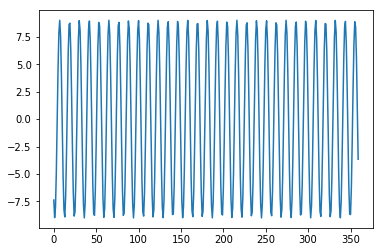

In [3]:
plt.plot(f_list);

We're going to implement the Fourier transform as given on Wolfram Alpha:
$$
F_n = \sum_{k=0}^{N-1} f_k e^{-2\pi ink/N}.
$$

In [4]:
from numpy import exp

#function to calculate the Discrete Fourier Transform
def DFT(f_list):
    N = len(f_list)
    DFT_list = []
    for n in range(N):
        Fn = 0.0
        for k in range(N):
            Fn += f_list[k] * exp(-2j * pi * n * k / N)
        DFT_list.append(Fn)
    return DFT_list        

In [5]:
DFT_list = DFT(f_list)

In [6]:
for n, coefficient in enumerate(DFT_list[:10]):
    print("F_{:<3d} = {}".format(n, coefficient))

F_0   = (3.5083047578154947e-14+0j)
F_1   = (4.529709940470639e-14-2.2583324099656465e-13j)
F_2   = (4.3431924723336124e-13+9.783840404509192e-14j)
F_3   = (-1.2656542480726785e-13+7.008282842946301e-14j)
F_4   = (-1.4344081478157023e-13-2.0161650127192843e-13j)
F_5   = (4.947153797729698e-13-7.505107646466058e-13j)
F_6   = (6.901146321069973e-13+4.619082893952964e-13j)
F_7   = (-6.17284001691587e-14+3.608224830031759e-13j)
F_8   = (-5.329070518200751e-15-1.291189377639057e-13j)
F_9   = (2.913225216616411e-13+2.73225886360251e-13j)


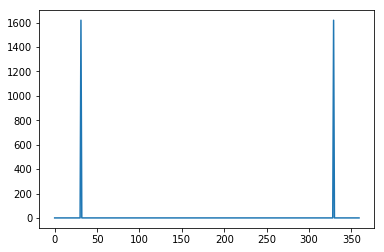

In [7]:
plt.plot(np.absolute(DFT_list));

We're going to implement the *inverse* Fourier transform as given on Wolfram Alpha:
$$
f_k = \frac{1}{N} \sum_{n=0}^{N-1} F_n e^{2\pi ikn/N}.
$$

In [8]:
#function to calculate the inverse Fourier transform
def inverse_DFT(DFT_list):
    N = len(DFT_list)
    f_list = []
    for k in range(N):
        fk = 0.0
        for n in range(N):
            fk += DFT_list[n] * exp(2j * pi * k * n / N)
        f_list.append(fk / N)
    return f_list        

In [9]:
f_list2 = inverse_DFT(DFT_list)

In [10]:
for n, (coefficient1, coefficient2) in enumerate(zip(f_list, f_list2[:10])):
    print("f_{:<3d} = {}\t{}".format(n, coefficient1, coefficient2))

f_0   = -7.3723683986009245	(-7.372368398601503-1.0720513982715513e-13j)
f_1   = -8.978076452338417	(-8.978076452338684+3.7521372696090596e-13j)
f_2   = -8.019058717695312	(-8.01905871769535+3.608907250328971e-13j)
f_3   = -4.769273378098845	(-4.769273378098712+3.2876088626249753e-13j)
f_4   = -0.15707165793555206	(-0.15707165793522407+8.602512471988812e-14j)
f_5   = 4.5	(4.500000000000474+2.2771515836707316e-14j)
f_6   = 7.871577364254563	(7.871577364254589-1.568913796489534e-13j)
f_7   = 8.994517443171862	(8.994517443171704-2.981243979917747e-13j)
f_8   = 7.54803511150882	(7.548035111508712+1.398593558212041e-13j)
f_9   = 3.945340321101701	(3.945340321101832-5.91844011286903e-14j)


Unfortunately, due to rounding errors, we're still seeing small imaginary values. They really are small. Let's calculate the largest absolute value of the imaginary parts:

In [11]:
np.max(np.abs(np.imag(f_list2)))

1.8922407388717813e-12

So, indeed, rounding errors. Let's make `f_list2` real by ignoring the imaginary part:

In [12]:
f_list2 = [np.real(u) for u in f_list2]

In [13]:
for n, (coefficient1, coefficient2) in enumerate(zip(f_list, f_list2[:10])):
    print("f_{:<3d} = {}\t{}".format(n, coefficient1, coefficient2))

f_0   = -7.3723683986009245	-7.372368398601503
f_1   = -8.978076452338417	-8.978076452338684
f_2   = -8.019058717695312	-8.01905871769535
f_3   = -4.769273378098845	-4.769273378098712
f_4   = -0.15707165793555206	-0.15707165793522407
f_5   = 4.5	4.500000000000474
f_6   = 7.871577364254563	7.871577364254589
f_7   = 8.994517443171862	8.994517443171704
f_8   = 7.54803511150882	7.548035111508712
f_9   = 3.945340321101701	3.945340321101832


Let's see if the original and recreated values are the same:

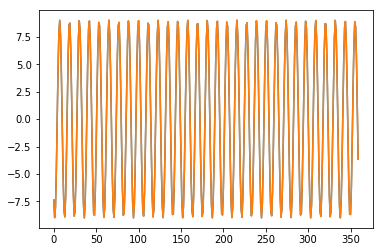

In [14]:
plt.plot(f_list)
plt.plot(f_list2);

They are! The plotted lines coincide.

### Again, but now with some NumPy magic

Calculating the original samples:

In [15]:
n = np.arange(N)
f_n = a * np.sin(np.radians(f * n + p))

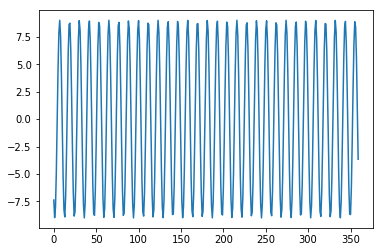

In [16]:
plt.plot(f_n);

Again, the Fourier transform as given on Wolfram Alpha:
$$
F_n = \sum_{k=0}^{N-1} f_k e^{-2\pi ink/N}.
$$
First, building values for $k$, and creating $f_k$, which is simply identical to $f_n$ (we only do this to be able to write down the python code as closely as possible to the mathematical formula):

In [17]:
k = np.arange(N)
f_k = f_n

Now, we calculate $F_n$. The entire calculation of the coefficients is done like this (explained below):

In [18]:
F_n = np.array([(f_k * exp(-2j * pi * n * k / N)).sum() for n in range(N)])

The inner part (`f_k * np.exp(... * k ...)`) uses NumPy magic. Because both `k` and `f_k` are NumPy arrays, they perform the calculation for all values of the array, without us requiring to build a loop. Multiplying the two arrays (using the `*` operator) simply performs element-wise multiplication, like this:

In [19]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
print(a)
print(b)
print(a * b)

[1 2 3]
[4 5 6]
[ 4 10 18]


The outer part (`[(...) for n in range(N)]`) is a list comprehension which loops over `n`, and creates a list, which we then turn into an array using `np.array()`. Then, we have an array of all $F_n$.

Unfortunately, we do have rounding errors in our calculations, leading to slightly different results between the two algorithms. The difference between the results can be significant, but only for very, very small values of the coefficients. We're only going to print the coefficients in the neighbourhood of our frequency `f`.

In [20]:
start, end = f - 10, f + 10
print('\tF_n\t\tDFT_list')
for n, (coefficient1, coefficient2) in enumerate(zip(F_n[start:end], DFT_list[start:end]), start):
    print("F_{:<3d} =\t{:.2e}\t{:.2e}".format(n, np.absolute(coefficient1), np.absolute(coefficient2)))

	F_n		DFT_list
F_21  =	4.42e-13	2.87e-13
F_22  =	4.13e-13	1.59e-13
F_23  =	8.41e-13	9.55e-13
F_24  =	5.64e-13	8.49e-13
F_25  =	1.18e-12	1.17e-12
F_26  =	1.27e-12	1.18e-12
F_27  =	3.69e-13	5.93e-13
F_28  =	2.29e-13	6.61e-13
F_29  =	1.85e-12	7.05e-13
F_30  =	2.65e-12	4.53e-12
F_31  =	1.62e+03	1.62e+03
F_32  =	7.73e-13	1.55e-12
F_33  =	1.82e-12	1.06e-12
F_34  =	4.73e-13	9.41e-13
F_35  =	5.49e-13	1.58e-12
F_36  =	7.95e-13	7.12e-13
F_37  =	1.98e-13	6.28e-13
F_38  =	6.32e-13	7.15e-13
F_39  =	3.84e-13	3.50e-14
F_40  =	5.65e-13	1.48e-12


We can plot the two results to visually inspect if they are (more or less) identical:

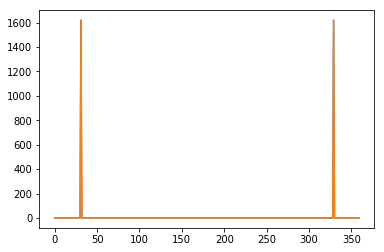

In [21]:
plt.plot(np.absolute(F_n))
plt.plot(np.absolute(DFT_list))

And again, the *inverse* Fourier transform as given on Wolfram Alpha:
$$
f_k = \frac{1}{N} \sum_{n=0}^{N-1} F_n e^{2\pi ikn/N}.
$$

In [22]:
n = np.arange(N)
f2_k = 1 / N * np.array([(F_n * exp(2j * pi * k * n / N)).sum() for k in range(N)])

In [23]:
for n, (coefficient1, coefficient2) in enumerate(zip(f_n, f2_k[:10])):
    print("f_{:<3d} = {}\t{}".format(n, coefficient1, coefficient2))
    
print("\nMaximum deviation from zero for the imaginary parts: {}j".format(np.max(np.abs(np.imag(f2_k)))))

f2_k = np.real(f2_k)

f_0   = -7.3723683986009245	(-7.372368398601197+1.0137076363510763e-13j)
f_1   = -8.978076452338417	(-8.978076452338701+2.2429465692160496e-13j)
f_2   = -8.019058717695312	(-8.019058717694952+5.371703082346358e-13j)
f_3   = -4.769273378098845	(-4.769273378098671-4.421154800285068e-14j)
f_4   = -0.15707165793555206	(-0.15707165793544803+1.1179205709292244e-13j)
f_5   = 4.5	(4.500000000000416+5.684341886080802e-14j)
f_6   = 7.871577364254563	(7.871577364254645-1.9926776278427698e-13j)
f_7   = 8.994517443171862	(8.994517443171704-3.8813396940895473e-13j)
f_8   = 7.54803511150882	(7.5480351115087085+6.789630586152068e-14j)
f_9   = 3.945340321101701	(3.9453403211017344-7.831759931933549e-14j)

Maximum deviation from zero for the imaginary parts: 1.7794358579218776e-12j


Again, rounding errors result in small imaginary values.

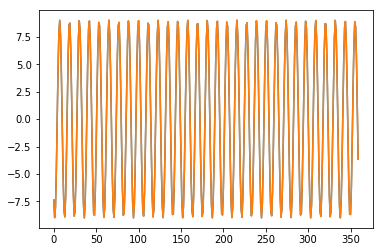

In [24]:
plt.plot(f_n)
plt.plot(f2_k);

### SciPy FFTpack

Of course, there must be some library we could use for one of the most-used transforms in signal processing. Enter SciPy.

In [25]:
from scipy.fftpack import fft

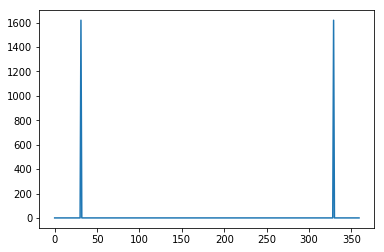

In [26]:
fft_result = fft(f_n)
plt.plot(np.absolute(fft_result))

Boom!

### Why bother with NumPy?

Well, for two reasons, basically. Firstly, once you get the hang of it, writing the Fourier transform using NumPy was *much* shorter than writing the function. Secondly, the NumPy code runs *much* faster. Let's time and compare the two methods:

In [27]:
%timeit DFT(f_list)

198 ms ± 6.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%timeit np.array([(f_k * exp(-2j * pi * n * k / N)).sum() for n in range(N)])

6.61 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


That's a speedup factor of about 20-30, depending on the exact signal.

### Even more magic: Numba

Numba speeds up your code by means of just-in-time compilation. It really works like magic. You can prepend your function with the `@jit` decorator, or if you want to compile an existing function, do it like this:

In [29]:
from numba import jit

compiled_DFT = jit(DFT)
%timeit compiled_DFT(f_list)

3.45 ms ± 83.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


That's about 2 times faster than the hand-optimized NumPy code, so 40-60 times faster than the original function.

Let that sink in: a speed up of 40 to 60 times by *only* applying a decorator to your function. Magic!

### ...and SciPy?

In [30]:
%timeit fft_result = fft(f_n)

6.1 µs ± 165 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Right. We can't beat heavily optimized C code. Even faster by a factor of 500. However, keep in mind that this function is not our own function, but written in C. It is almost certainly an entirely different beast, on which a team of programmers have worked for many hours.

## Part 2

### Generating a tone and plotting a spectrogram

In [31]:
from scipy import signal

In [32]:
def make_tone(frequency, samplerate, duration):
    t = np.arange(0, duration, 1 / samplerate)
    signal = np.sin(2 * pi * frequency * t)
    return t, signal

In [33]:
SAMPLE_RATE = 44100
_, tone = make_tone(1000, SAMPLE_RATE, 2)

In [34]:
freq, time, psd = signal.spectrogram(tone, fs=SAMPLE_RATE)

The function `pcolormesh` wants the arguments reversed or the color values transposed. I don't know why, but you can flip the $x-$ and $y-$axes and *not* transpose the power spectral density array.

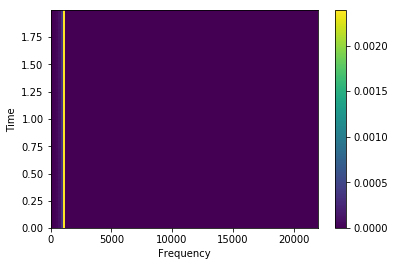

In [35]:
f = plt.pcolormesh(freq, time, psd.T)
plt.colorbar(f)
plt.xlabel("Frequency")
plt.ylabel("Time");

### Comparing two resampling methods: `resampy.resample` and `scipy.signal.resample`

In [36]:
import resampy

NEW_SAMPLE_RATE = 16000

In [37]:
def plot_spectrogram(s, sample_rate):
    freq, time, psd = signal.spectrogram(s, fs=sample_rate)
    f = plt.pcolormesh(freq, time, psd.T)
    plt.colorbar(f)
    plt.xlabel("Frequency")
    plt.ylabel("Time");

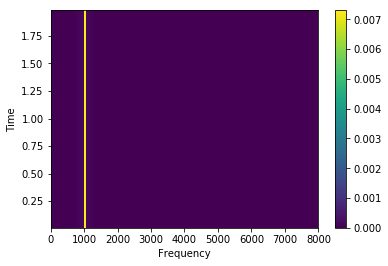

In [38]:
resampled1 = resampy.resample(tone, SAMPLE_RATE, NEW_SAMPLE_RATE)
plot_spectrogram(resampled1, NEW_SAMPLE_RATE)

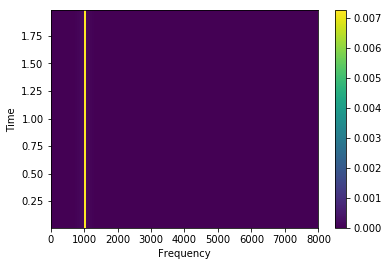

In [39]:
duration = len(tone) / SAMPLE_RATE
num_samples = int(duration * NEW_SAMPLE_RATE)
resampled2 = signal.resample(tone, num=num_samples)
plot_spectrogram(resampled2, NEW_SAMPLE_RATE)

### Repeat, using a sample audio file

In [40]:
from scipy.io import wavfile

Import the audio file and only take the first two seconds from the left audio channel. This makes it easier to visually inspect the spectrogram.

In [41]:
sample_rate, audio = wavfile.read('muziek_48kHz.wav')
sample = audio[:2 * sample_rate, 0]

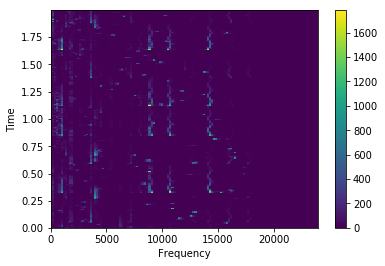

In [42]:
plot_spectrogram(sample, sample_rate)

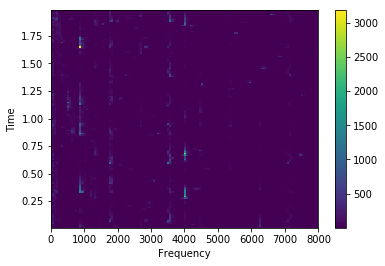

In [43]:
resampled1 = resampy.resample(sample, sample_rate, NEW_SAMPLE_RATE)
plot_spectrogram(resampled1, NEW_SAMPLE_RATE)

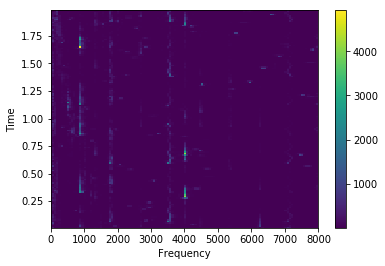

In [44]:
duration = len(sample) / sample_rate
num_samples = int(duration * NEW_SAMPLE_RATE)
resampled2 = signal.resample(sample, num=num_samples)
plot_spectrogram(resampled2, NEW_SAMPLE_RATE)

Both resampling methods seem to return more or less the same result. Of course, since we resample down to 16000 samples per second, we lose all frequency components above 8000 Hz. In that sense, the resampled signal is very different from the original. Still, both `resampy` and `scipy.signal` seem to do a decent job. Let's make sure the two methods actually *are* different:

In [45]:
resampled1 == resampled2

array([False, False, False, ..., False, False, False])

Well, that settles it. They are numerically different, but both spectrograms look about the same.

## Part 3

Consider the signal: $y(t) = 3\cos(2\pi\cdot 10 t) + 2\cos(2\pi\cdot 20t) + \sin(2\pi\cdot 30t).$

In [46]:
from numpy import sin, cos

y = lambda t: 3 * cos(2 * pi * 10 * t) + 2 * cos(2 * pi * 20 * t) + sin(2 * pi * 30 * t)

In [47]:
sample_rate = 100
duration = 1

t = np.arange(0, duration, 1 / sample_rate)
sample = y(t)

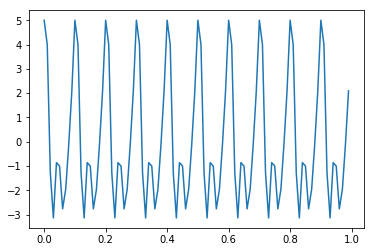

In [48]:
plt.plot(t, sample);

Visually inspecting the signal, you can see that the sampling rate is too low to capture the signal adequately.

Let's not do the Fourier transform manually again, but resort to `scipy`.

In [49]:
from scipy.fftpack import fft

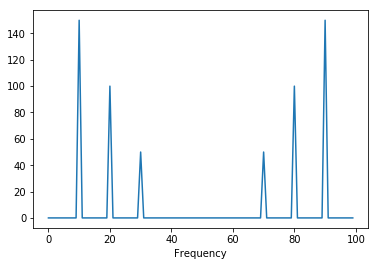

In [50]:
fft_result = fft(sample)
plt.plot(np.absolute(fft_result))
plt.xlabel("Frequency");

A sinc low-pass filter with cutoff frequency $B_L$ is given by:
$$
h_\mathrm{LPF}(t) = 2B_L\mathrm{sinc}(2B_Lt).
$$
We will use a cutoff frequency $B_L = 25$ Hz.

In [51]:
B_L = 25

t_filter = np.arange(-duration, duration, 1 / sample_rate)
lowpass_filter = 2 * B_L * np.sinc(2 * B_L * t_filter)

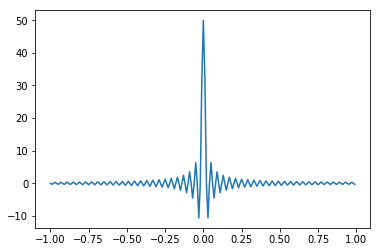

In [52]:
plt.plot(t_filter, lowpass_filter);

In [53]:
filtered_sample = np.convolve(sample, lowpass_filter, mode='valid')

Cut off the last sample (the convolution is 1 sample longer than the input):

In [54]:
filtered_sample = filtered_sample[:-1]

...and look at the result:

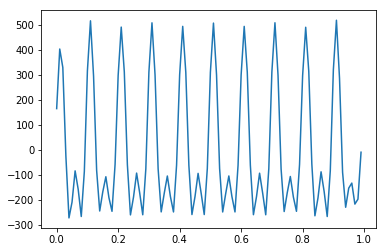

In [55]:
plt.plot(t, filtered_sample);

The higher frequency is indeed cut off:

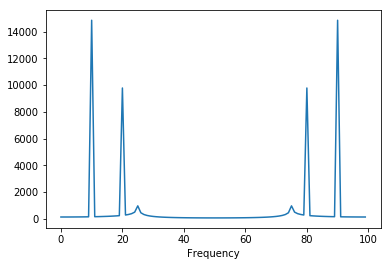

In [56]:
fft_result = fft(filtered_sample)
plt.plot(np.absolute(fft_result))
plt.xlabel("Frequency");

A sinc high-pass filter with cutoff frequency $B_L$ is given by:
$$
h_\mathrm{HPF}(t) = -2B_H\mathrm{sinc}(2B_Ht).
$$
We will use a cutoff frequency $B_H = 15$ Hz.

In [57]:
B_H = 15

t_filter = np.arange(-duration, duration, 1 / sample_rate)
highpass_filter = -2 * B_H * np.sinc(2 * B_H * t_filter)

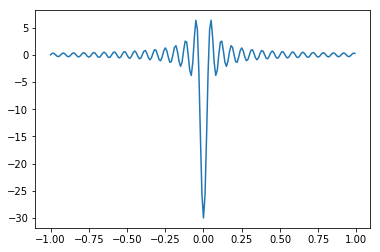

In [58]:
plt.plot(t_filter, highpass_filter);

In [59]:
filtered_sample = np.convolve(sample, highpass_filter, mode='valid')

Cut off the last sample (the convolution is 1 sample longer than the input):

In [60]:
filtered_sample = filtered_sample[:-1]

...and look at the result:

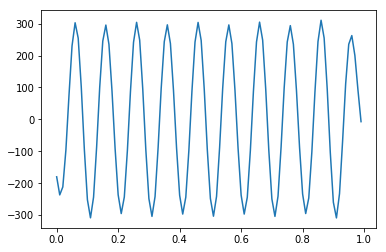

In [61]:
plt.plot(t, filtered_sample);

This does *not* look good.

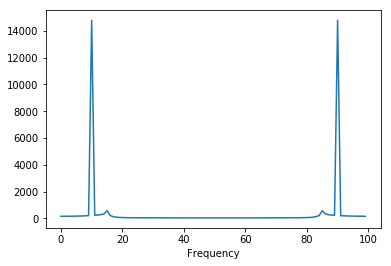

In [62]:
fft_result = fft(filtered_sample)
plt.plot(np.absolute(fft_result))
plt.xlabel("Frequency");

No, indeed. Fail.